In [4]:
import os
from PIL import Image
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from tqdm import tqdm

# --- Paths ---
base_dir = 'dtd-r1.0.1/dtd'
image_dir = os.path.join(base_dir, 'images')
label_file = os.path.join(base_dir, 'labels', 'train1.txt')  # Change this for val/test

# --- Parameters for GLCM and Gabor ---
distances = [1, 2, 3]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
gabor_frequencies = [0.1, 0.2, 0.3]
gabor_thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]

In [5]:
# --- Feature extractors ---
def extract_glcm_features(img_gray):
    glcm = graycomatrix(img_gray, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)
    features = []
    for prop in ['contrast', 'correlation', 'ASM', 'energy', 'homogeneity']:
        features.append(np.mean(graycoprops(glcm, prop)))
    return features

In [6]:
def extract_gabor_features(img_gray):
    features = []
    for theta in gabor_thetas:
        for frequency in gabor_frequencies:
            filt_real, filt_imag = gabor(img_gray, frequency=frequency, theta=theta)
            features.append(filt_real.mean())
            features.append(filt_real.var())
    return features

In [7]:
# --- Main loader ---
def load_features_and_labels(label_file, use_gabor=True, use_glcm=True):
    features = []
    labels = []

    with open(label_file, 'r') as f:
        image_list = [line.strip() for line in f.readlines()]

    for rel_path in tqdm(image_list, desc="Processing images"):
        label = rel_path.split('/')[0]  # folder name is label
        full_path = os.path.join(image_dir, rel_path)

        try:
            img = Image.open(full_path).convert('L')  # grayscale
            img = img.resize((128, 128))  # Resize for consistency
            img_np = np.array(img)

            feats = []
            if use_glcm:
                feats += extract_glcm_features(img_np)
            if use_gabor:
                feats += extract_gabor_features(img_np)

            features.append(feats)
            labels.append(label)

        except Exception as e:
            print(f"Failed to process {rel_path}: {e}")
            continue

    return np.array(features), np.array(labels)

In [10]:
X, y = load_features_and_labels('dtd-r1.0.1/dtd/labels/train1.txt')
print("Feature shape:", X.shape)
print("Labels shape:", y.shape)

Processing images:   0%|          | 0/1880 [00:00<?, ?it/s]

Processing images: 100%|██████████| 1880/1880 [17:47<00:00,  1.76it/s]

Feature shape: (1880, 29)
Labels shape: (1880,)


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is the array of label strings

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

      banded       0.62      0.62      0.62         8
     blotchy       0.11      0.12      0.12         8
     braided       0.14      0.12      0.13         8
      bubbly       0.29      0.25      0.27         8
       bumpy       0.50      0.12      0.20         8
   chequered       0.86      0.75      0.80         8
   cobwebbed       0.10      0.12      0.11         8
     cracked       0.38      0.38      0.38         8
crosshatched       0.50      0.38      0.43         8
 crystalline       0.06      0.12      0.08         8
      dotted       0.29      0.25      0.27         8
     fibrous       0.11      0.12      0.12         8
     flecked       0.06      0.12      0.08         8
    freckled       0.20      0.25      0.22         8
      frilly       0.00      0.00      0.00         8
       gauzy       0.40      0.50      0.44         8
        grid       0.38      0.38      0.38         8
     grooved       0.25    

In [14]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


              precision    recall  f1-score   support

      banded       0.50      0.62      0.56         8
     blotchy       0.00      0.00      0.00         8
     braided       0.00      0.00      0.00         8
      bubbly       0.00      0.00      0.00         8
       bumpy       0.33      0.12      0.18         8
   chequered       0.86      0.75      0.80         8
   cobwebbed       0.00      0.00      0.00         8
     cracked       0.12      0.25      0.16         8
crosshatched       0.14      0.12      0.13         8
 crystalline       0.03      0.12      0.05         8
      dotted       0.29      0.25      0.27         8
     fibrous       0.18      0.38      0.24         8
     flecked       0.18      0.25      0.21         8
    freckled       0.00      0.00      0.00         8
      frilly       0.00      0.00      0.00         8
       gauzy       0.36      0.62      0.45         8
        grid       0.33      0.12      0.18         8
     grooved       0.25    

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
IMG_SIZE = (128, 128)

def load_image_for_cnn(img_path, size=IMG_SIZE):
    try:
        img = imread(img_path)
        img = resize(img, size, anti_aliasing=True)
        return img  # Keep RGB
    except:
        return None

print("⏳ Loading images for CNN...")
X_img, y_img = [], []
for path, label in tqdm(zip(image_paths, labels), desc="Loading CNN images", total=len(image_paths)):
    img = load_image_for_cnn(path)
    if img is not None:
        X_img.append(img)
        y_img.append(label)

X_img = np.array(X_img, dtype=np.float32)
y_img = np.array(y_img)
y_img_cat = to_categorical(y_img)


⏳ Loading images for CNN...


Loading CNN images: 100%|██████████| 5640/5640 [01:47<00:00, 52.53it/s]


In [4]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,398,383 (28.22 MB)

 Trainable params: 7,398,383 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(
    X_img, y_img_cat, test_size=0.2, stratify=y_img, random_state=42
)


In [6]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,398,383 (28.22 MB)

 Trainable params: 7,398,383 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = cnn_model.fit(
    X_img_train, y_img_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 0.0209 - loss: 4.0541 - val_accuracy: 0.0177 - val_loss: 3.8320
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.0370 - loss: 3.8095 - val_accuracy: 0.0310 - val_loss: 3.7952
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.0682 - loss: 3.7021 - val_accuracy: 0.0531 - val_loss: 3.7888
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.1220 - loss: 3.4965 - val_accuracy: 0.0774 - val_loss: 3.7175
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - accuracy: 0.2270 - loss: 3.1353 - val_accuracy: 0.0819 - val_loss: 3.8747
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.3310 - loss: 2.7261 - val_accuracy: 0.1018 - val_loss: 4.1012
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.4369 - loss: 2.3070 - val_accuracy: 0.1062 - val_loss: 4.3534
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.5156 - loss: 1


--- CNN Model ---
Accuracy: 0.1463
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

Classification Report:
               precision    recall  f1-score   support

      banded       0.09      0.17      0.12        24
     blotchy       0.17      0.04      0.07        24
     braided       0.10      0.12      0.11        24
      bubbly       0.17      0.08      0.11        24
       bumpy       0.03      0.04      0.03        24
   chequered       0.26      0.38      0.31        24
   cobwebbed       0.42      0.33      0.37        24
     cracked       0.11      0.21      0.14        24
crosshatched       0.18      0.08      0.11        24
 crystalline       0.11      0.04      0.06        24
      dotted       0.50      0.25      0.33        24
     fibrous       0.00      0.00      0.00        24
     flecked       0.17      0.17      0.17        24
    freckled       0.19      0.21      0.20        24
      frilly       0.25      0.08      0.12        24
       gauzy       0.08      0.17 

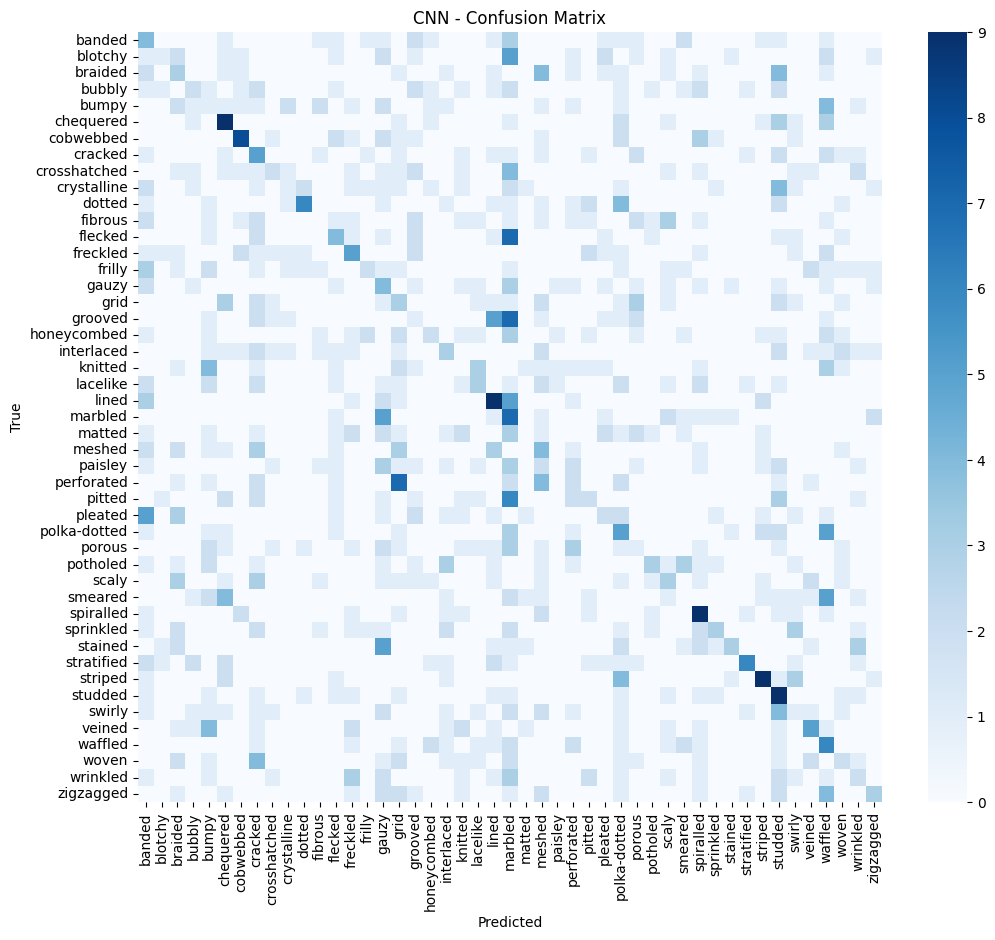

In [8]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_img_test, y_img_test, verbose=0)
print(f"\n--- CNN Model ---\nAccuracy: {cnn_acc:.4f}")

# Predictions and classification report
y_img_pred = np.argmax(cnn_model.predict(X_img_test), axis=1)
y_img_true = np.argmax(y_img_test, axis=1)

print("\nClassification Report:\n", classification_report(y_img_true, y_img_pred, target_names=final_label_names))

cm = confusion_matrix(y_img_true, y_img_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=final_label_names, yticklabels=final_label_names, cmap='Blues', annot=False)
plt.title("CNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
